# K - Means Clustering

The steps of analysis is :
 - read and visualise the data
 - Clean the data
 - Preparation of the data
 - Modeling
 - Final analysis and recommendation

### Read and visualise the data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
retail_df = pd.read_csv("Online+Retail.csv", encoding="ISO-8859-1", header=0)
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom


In [3]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


### Clean the data

In [4]:
retail_df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
#calculate the percent of missing value
round(retail_df.isnull().sum() / len(retail_df) * 100, 2)

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [6]:
retail_df = retail_df.dropna()
retail_df.shape

(406829, 8)

In [7]:
retail_df['amount'] = retail_df['Quantity'] * retail_df['UnitPrice']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom,20.34


### Prepare the data for modelling

- R (Recency) : Number of days since last purchase
- F (Frequence) : Number of transactions
- M (Monetary) : Total amount of transactions (revenue contributed)

In [8]:
# Group based on customer id and aggreate for amount
grouped_df = retail_df.groupby('CustomerID')['amount'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,CustomerID,amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [9]:
# Group based on customer id and aggreate for frequency
frequency = retail_df.groupby('CustomerID')['InvoiceNo'].count()
frequency = frequency.reset_index()
frequency.head()

,CustomerID,InvoiceNo
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [10]:
#Merge the amount and freqency data frames
grouped_df = pd.merge(grouped_df, frequency, on='CustomerID', how='inner')
grouped_df.head()

,CustomerID,amount,InvoiceNo
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [11]:
retail_df["InvoiceDate"] = pd.to_datetime(retail_df['InvoiceDate'], format='%d-%m-%Y %H:%M')

In [12]:
retail_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   amount       406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB


In [13]:
max_date = max(retail_df['InvoiceDate'])
print(max_date)

2011-12-09 12:50:00


In [14]:
#Calculate recency based on Invoice date
retail_df['diff'] = max_date - retail_df['InvoiceDate']
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,amount,diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [15]:
last_purchase = retail_df.groupby('CustomerID')['diff'].min()
last_purchase = last_purchase.reset_index()
last_purchase.head()

,CustomerID,diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [16]:
grouped_df = pd.merge(grouped_df, last_purchase, on='CustomerID', how='inner')
grouped_df.columns = ['CustomerID', 'amount', 'frequency', 'recency']
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325 days 02:33:00
1,12347.0,4310.00,182,1 days 20:58:00
2,12348.0,1797.24,31,74 days 23:37:00
3,12349.0,1757.55,73,18 days 02:59:00
4,12350.0,334.40,17,309 days 20:49:00


In [17]:
grouped_df['recency'] = grouped_df['recency'].dt.days

In [18]:
grouped_df.head()

,CustomerID,amount,frequency,recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


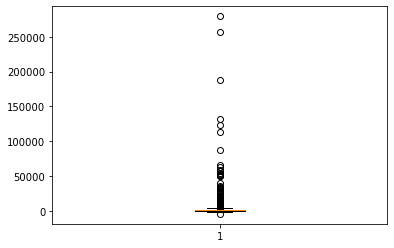

In [19]:
# 1. outlier treatment
#fig, axs = plt.subplots(ncols=3)
plt.boxplot(grouped_df['amount'])
plt.show()

In [20]:
# removing (statistical) outliers
Q1 = grouped_df.amount.quantile(0.05)
Q3 = grouped_df.amount.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.amount >= Q1 - 1.5*IQR) & (grouped_df.amount <= Q3 + 1.5*IQR)]

# outlier treatment for recency
Q1 = grouped_df.recency.quantile(0.05)
Q3 = grouped_df.recency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.recency >= Q1 - 1.5*IQR) & (grouped_df.recency <= Q3 + 1.5*IQR)]

# outlier treatment for frequency
Q1 = grouped_df.frequency.quantile(0.05)
Q3 = grouped_df.frequency.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.frequency >= Q1 - 1.5*IQR) & (grouped_df.frequency <= Q3 + 1.5*IQR)]

In [21]:
# 2. Rescaling
rfm_df = grouped_df[['amount', 'frequency', 'recency']]

# Initilization of scaler 
scaler = StandardScaler()

# Fit and Transform (rescaling)
rfm_scaled = scaler.fit_transform(rfm_df)
rfm_scaled.shape

(4293, 3)

In [22]:
rfm_df_scaled = pd.DataFrame(rfm_scaled)
rfm_df_scaled.columns = ['amount', 'frequency', 'recency']
rfm_df_scaled.head()

,amount,frequency,recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


### Modelling

In [23]:
# Model using KMeans with some settings
kmeans = KMeans(n_clusters=4, max_iter=50)

kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=4)

In [24]:
kmeans.labels_

array([1, 0, 3, ..., 1, 3, 3], dtype=int32)

#### Find the optimal number of clusters

In [25]:
# elbow curve/SSD (Sum of Square Distance)
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

ssd=[]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    ssd.append(kmeans.inertia_)

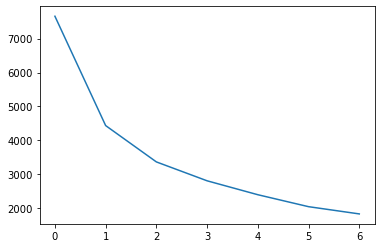

In [26]:
plt.plot(ssd)
plt.show()

### Silhouette Analysis

In [27]:
# Silhouette Score = (p - q)/max(p, q) 

# p : mean distance to the points in nearest cluster
# q : mean intra-cluster distance to the points in own cluster

In [28]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_label = kmeans.labels_
    
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_label)
    
    print("For n_clusters = {0}, the silhoutte score is {1}".format(num_clusters, silhouette_avg))

For n_clusters = 2, the silhoutte score is 0.5415858652525395
For n_clusters = 3, the silhoutte score is 0.5084896296141937
For n_clusters = 4, the silhoutte score is 0.47943362518683813
For n_clusters = 5, the silhoutte score is 0.46627005641897035
For n_clusters = 6, the silhoutte score is 0.4174586253598392
For n_clusters = 7, the silhoutte score is 0.4178829558377894
For n_clusters = 8, the silhoutte score is 0.4096596950024799


In [29]:
# We found the optimal number of clusters is 3 based on elbow curve and silhouette analysis

In [30]:
# Modeling the cluster with k = 3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [31]:
grouped_df['cluster_id'] = kmeans.labels_
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id
0,12346.0,0.00,2,325,2
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,1
3,12349.0,1757.55,73,18,1
4,12350.0,334.40,17,309,2


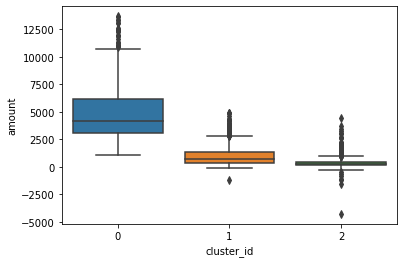

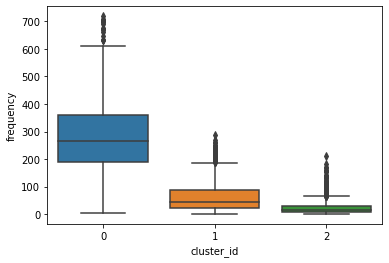

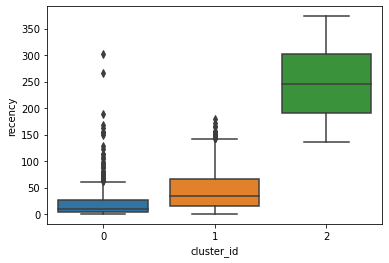

In [32]:
sns.boxplot(x = 'cluster_id', y = 'amount', data=grouped_df)
plt.show()

sns.boxplot(x = 'cluster_id', y = 'frequency', data=grouped_df)
plt.show()

sns.boxplot(x = 'cluster_id', y = 'recency', data=grouped_df)
plt.show()

### Hirerachial Clustering

In [33]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

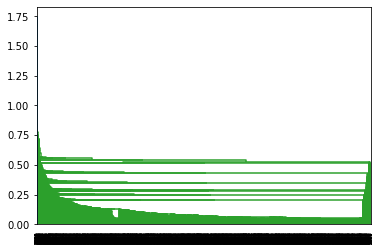

In [34]:
mergings = linkage(rfm_df_scaled, method='single', metric='euclidean')
dendrogram(mergings)
plt.show()

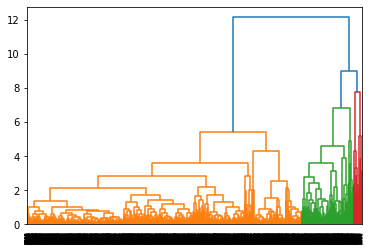

In [35]:
mergings = linkage(rfm_df_scaled, method='complete', metric='euclidean')
dendrogram(mergings)
plt.show()

In [36]:
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 0, ..., 0, 0, 0])

In [37]:
grouped_df['cluster_labels'] = cluster_labels
grouped_df.head()

,CustomerID,amount,frequency,recency,cluster_id,cluster_labels
0,12346.0,0.00,2,325,2,0
1,12347.0,4310.00,182,1,0,1
2,12348.0,1797.24,31,74,1,0
3,12349.0,1757.55,73,18,1,0
4,12350.0,334.40,17,309,2,0


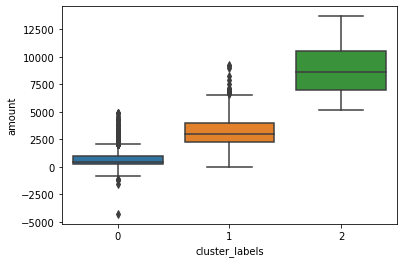

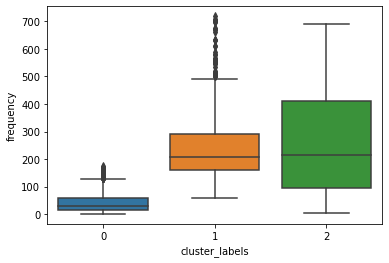

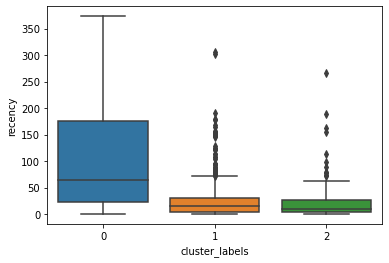

In [38]:
sns.boxplot(x = 'cluster_labels', y = 'amount', data=grouped_df)
plt.show()

sns.boxplot(x = 'cluster_labels', y = 'frequency', data=grouped_df)
plt.show()

sns.boxplot(x = 'cluster_labels', y = 'recency', data=grouped_df)
plt.show()

### Clustering Assignment

In [39]:
cricket_df = pd.read_csv('Cricket.csv',encoding="ISO-8859-1", header=0)
cricket_df.head()

,Player,Span,Mat,Inns,NO,Runs,HS,Ave,BF,SR,100,50,0
0,SR Tendulkar (INDIA),1989-2012,463,452,41,18426,200*,44.83,21367,86.23,49,96,20
1,KC Sangakkara (Asia/ICC/SL),2000-2015,404,380,41,14234,169,41.98,18048,78.86,25,93,15
2,RT Ponting (AUS/ICC),1995-2012,375,365,39,13704,164,42.03,17046,80.39,30,82,20
3,ST Jayasuriya (Asia/SL),1989-2011,445,433,18,13430,189,32.36,14725,91.20,28,68,34
4,DPMD Jayawardene (Asia/SL),1998-2015,448,418,39,12650,144,33.37,16020,78.96,19,77,28


In [40]:
players_df = cricket_df[['Player', 'Ave', 'SR']]
players_df.head()

,Player,Ave,SR
0,SR Tendulkar (INDIA),44.83,86.23
1,KC Sangakkara (Asia/ICC/SL),41.98,78.86
2,RT Ponting (AUS/ICC),42.03,80.39
3,ST Jayasuriya (Asia/SL),32.36,91.20
4,DPMD Jayawardene (Asia/SL),33.37,78.96


In [41]:
# 2. Rescaling
rfm_df2 = players_df[['Ave', 'SR']]

# Initilization of scaler 
scaler = StandardScaler()

# Fit and Transform (rescaling)
rfm_scaled2 = scaler.fit_transform(rfm_df2)

In [42]:
rfm_df_scaled2 = pd.DataFrame(rfm_scaled2)
rfm_df_scaled2.columns = ['Ave', 'SR']
rfm_df_scaled2.head()

,Ave,SR
0,1.072294,0.703152
1,0.587725,-0.044139
2,0.596226,0.110997
3,-1.047909,1.207091
4,-0.876185,-0.034000


In [43]:
# Model using KMeans with some settings
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=100)

kmeans.fit(rfm_df_scaled2)

KMeans(max_iter=50, n_clusters=4, random_state=100)

In [44]:
players_df['cluster_id'] = kmeans.labels_

In [46]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(players_df.sort_values(by=['cluster_id'], ascending=False))

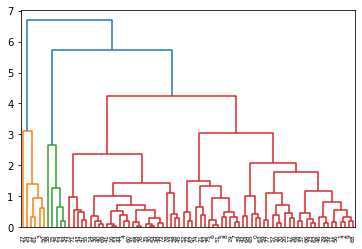

In [48]:
mergings2 = linkage(rfm_df_scaled2, method='complete', metric='euclidean')
dendrogram(mergings2)
plt.show()